# Using Base Neural Architectures

In this notebook, the task of stance detection is tackled through neural architectures in a fully supervised way, without adoption of any pre-trained model.

## Imports and Setup

In [1]:
import torch

In [30]:
from datasets import SemEval
from torch import nn, optim
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
import numpy as np
from math import ceil
from warnings import filterwarnings
from utils import get_batch, plot_confusion_matrix

In [4]:
filterwarnings("ignore")

The following cells contains functionalities used for the pre-processing and vectorisation of text into numeric form; used as inputs to the networks.

In [5]:
def tokenise(text):        
    return text.lower().split()

In [6]:
def get_vocabulary(texts):
    vocabulary = {
        "[PAD]": 0,
        "[UNK]": 1,
        "[SEP]": 2,
        "[SOS]": 3,
        "[EOS]": 4,
    }
    for text in texts:
        for token in tokenise(text):
            if token not in vocabulary:
                vocabulary[token] = len(vocabulary)
    return vocabulary

In [7]:
def _vectorise(text, vocabulary):
    return [vocabulary[token] if token in vocabulary else vocabulary["[UNK]"] for token in tokenise(text)]

In [8]:
def vectorise(texts, vocabulary):
    return [_vectorise(text, vocabulary) for text in texts]

In [9]:
def tensorise(texts, vocabulary, maximum_length=None):
    vectors = vectorise(texts, vocabulary)
    maximum_length = max(max([len(vector) for vector in vectors]), maximum_length if maximum_length else 0)
    _vectors = []
    for vector in vectors:
        v = vector[:maximum_length] + [vocabulary["[PAD]"]] * (maximum_length - len(vector))
        _vectors.append(v)
    return torch.tensor(_vectors).cuda()

In [39]:
class TRNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.text_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(embedding_size, 3), nn.Softmax(dim=1))
        
    def forward(self, texts, labels):
        _, (hidden_state, _) = self.text_rnn(self.embedding(texts))
        hidden_state = hidden_state.transpose(0, 1).reshape(texts.shape[0], -1)
        probabilities = self.classifier(hidden_state)
        cross_entropy_loss = nn.CrossEntropyLoss()
        loss = cross_entropy_loss(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), loss

In [40]:
class TTRNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.text_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True)
        self.target_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(embedding_size, 3), nn.Softmax(dim=1))
        
    def forward(self, texts, targets, labels):
        _, (hidden_state, cell_state) = self.target_rnn(self.embedding(targets))
        _, (hidden_state, _) = self.text_rnn(self.embedding(texts), (torch.zeros_like(hidden_state), cell_state))
        hidden_state = hidden_state.squeeze()
        probabilities = self.classifier(hidden_state)
        cross_entropy_loss = nn.CrossEntropyLoss()
        loss = cross_entropy_loss(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), loss

In [41]:
class TBRNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.text_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(nn.Linear(embedding_size * 2, 3), nn.Softmax(dim=1))
        
    def forward(self, texts, labels):
        _, (hidden_state, _) = self.text_rnn(self.embedding(texts))
        hidden_state = hidden_state.transpose(0, 1).reshape(texts.shape[0], -1)
        probabilities = self.classifier(hidden_state)
        cross_entropy_loss = nn.CrossEntropyLoss()
        loss = cross_entropy_loss(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), loss

In [42]:
class TTBRNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.text_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True, bidirectional=True)
        self.target_rnn = nn.LSTM(embedding_size, embedding_size, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(nn.Linear(embedding_size * 2, 3), nn.Softmax(dim=1))
        
    def forward(self, texts, targets, labels):
        _, (hidden_state, cell_state) = self.target_rnn(self.embedding(targets))
        _, (hidden_state, _) = self.text_rnn(self.embedding(texts), (torch.zeros_like(hidden_state), cell_state))
        hidden_state = hidden_state.transpose(0, 1).reshape(texts.shape[0], -1)
        probabilities = self.classifier(hidden_state)
        cross_entropy_loss = nn.CrossEntropyLoss()
        loss = cross_entropy_loss(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), loss

In [277]:
class TCNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.convolution = nn.Sequential(nn.Conv1d(embedding_size, 16, 3, padding=1), nn.MaxPool1d(2), nn.Conv1d(16, 4, 3, padding=1), nn.MaxPool1d(2))
        self.classifier = nn.Sequential(nn.Linear(32, 3), nn.Softmax(dim=1)) 
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, texts, labels):
        z = self.embedding(texts)
        z = self.convolution(z.transpose(1, 2))
        z = self.classifier(z.reshape(-1, 32))
        loss = self.cross_entropy(z, labels)
        return z, torch.argmax(z, 1), loss

In [278]:
class TTCNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.text_convolution = nn.Sequential(nn.Conv1d(embedding_size, 16, 3, padding=1), nn.MaxPool1d(2), nn.Conv1d(16, 4, 3, padding=1), nn.MaxPool1d(2))
        self.target_convolution = nn.Sequential(nn.Conv1d(embedding_size, 4, 2, padding=1), nn.MaxPool1d(2))
        self.classifier = nn.Sequential(nn.Linear(44, 3), nn.Softmax(dim=1)) 
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, texts, targets, labels):
        text_output   = self.text_convolution(self.embedding(texts).transpose(1, 2))
        target_output = self.target_convolution(self.embedding(targets).transpose(1, 2))
        output = torch.cat([text_output.reshape(-1, 32), target_output.reshape(-1, 12)], 1)
        probabilities = self.classifier(output)
        loss = self.cross_entropy(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), loss

In [279]:
class TTCRNN(nn.Module):
    
    def __init__(self, embedding_size, vocabulary_size):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.target_rnn = nn.LSTM(embedding_size, 16, batch_first=True)
        self.text_rnn = nn.LSTM(embedding_size, 16, batch_first=True)
        self.text_convolution = nn.Sequential(nn.Conv1d(embedding_size, 16, 3, padding=1), nn.MaxPool1d(2), nn.Conv1d(16, 4, 3, padding=1), nn.MaxPool1d(2))
        self.target_convolution = nn.Sequential(nn.Conv1d(embedding_size, 4, 2, padding=1), nn.MaxPool1d(2))
        self.classifier = nn.Sequential(nn.Linear(60, 16), nn.Sigmoid(), nn.Linear(16, 3), nn.Softmax(dim=1)) 
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, texts, targets, labels):
        _, (hidden_state, cell_state) = self.target_rnn(self.embedding(targets))
        _, (hidden_state, _) = self.text_rnn(self.embedding(targets), (torch.zeros_like(hidden_state), cell_state))
        text_output   = self.text_convolution(self.embedding(texts).transpose(1, 2))
        target_output = self.target_convolution(self.embedding(targets).transpose(1, 2))
        output = torch.cat([text_output.reshape(-1, 32), target_output.reshape(-1, 12), hidden_state.squeeze()], 1)
        probabilities = self.classifier(output)
        loss = self.cross_entropy(probabilities, labels)
        return probabilities, torch.argmax(probabilities, 1), loss

In [280]:
def get_model(state_dict=None):
    model = TTCRNN(32, len(vocabulary)).cuda()
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return model

## Training
The training and testing data is firstly loaded, the vocabulary is formed and it is used to tensorise the data. The training loop is then started and the loss values and evaluation metrics are recorded.

In [244]:
training, testing = SemEval.get_subtask_a_datasets("data/semeval/")

In [245]:
vocabulary = get_vocabulary(training.texts + training.targets)

In [246]:
text_length   = max([len(tokenise(text)) for text in training.texts])
target_length = max([len(tokenise(target)) for target in training.targets])

In [247]:
_z = tensorise(training.texts + testing.texts, vocabulary, maximum_length=text_length)
training_inputs = _z[:len(training)], tensorise(training.targets, vocabulary, maximum_length=target_length), torch.tensor(training.stances).cuda()
testing_inputs  = _z[len(training):], tensorise(testing.targets,  vocabulary, maximum_length=target_length), torch.tensor(testing.stances).cuda()

In [289]:
model = get_model()

In [290]:
batch_size = 48
early_stopping = 4000
optimiser = optim.Adam(model.parameters(), lr=1e-3)

In [291]:
batches = ceil(len(training) / batch_size)
batches

61

In [292]:
results = {
    "training": {
        "cross_entropy_loss": [],
        "f_1_2": [],
        "f_1_3": []
    },
    "testing": {
        "cross_entropy_loss": [],
        "f_1_2": [],
        "f_1_3": []
    }
}

In [293]:
step, steps_since_improvement = 0, 0

In [294]:
optimal_score, optimal_model_state_dict = 0., None

In [295]:
while steps_since_improvement < early_stopping:
    
    batch = get_batch(step, batch_size, training_inputs)
    
    _, predictions, loss = model(*batch)
    scores = f1_score(batch[-1].cpu(), predictions.cpu(), average=None)
    scores = (np.mean(scores[1:]), np.mean(scores[:]))
    
    results["training"]["cross_entropy_loss"].append(float(loss))
    results["training"]["f_1_2"].append(scores[0])
    results["training"]["f_1_3"].append(scores[1])
    
    loss.backward()
    optimiser.step()
    model.zero_grad()
    
    _, predictions, loss = model(*testing_inputs)
    scores = f1_score(testing.stances, predictions.cpu(), average=None)
    scores = (np.mean(scores[1:]), np.mean(scores[:]))
    
    results["testing"]["cross_entropy_loss"].append(float(loss))
    results["testing"]["f_1_2"].append(scores[0])
    results["testing"]["f_1_3"].append(scores[1])
    
    score = np.mean(scores)
    
    if score > optimal_score:
        optimal_score, optimal_model_state_dict = score, deepcopy(model.state_dict())
        print("{}\t{}\t{}\t{}".format(step, *scores, score))
        steps_since_improvement = 0
    else:
        steps_since_improvement += 1
    
    step += 1

0	0.4463603623267488	0.2975735748844992	0.371966968605624
1	0.5697889326594676	0.37985928843964506	0.4748241105495563
30	0.6293098047020407	0.41953986980136043	0.5244248372517005
31	0.6365524566018267	0.4243683044012178	0.5304603805015222
140	0.6522428404011613	0.4348285602674409	0.5435357003343011
646	0.6527937774420471	0.4380818545140343	0.5454378159780408
650	0.6523284888727869	0.44343266779553314	0.54788057833416
827	0.6527659685795388	0.4436518886575456	0.5482089286185422
868	0.6331121546856284	0.46636381407946326	0.5497379843825458
869	0.6382305884705765	0.46896531984994955	0.553597954160263
927	0.6188959921317925	0.48922568057828314	0.5540608363550378
929	0.62078231980637	0.4877129945453545	0.5542476571758622
931	0.6232076000305631	0.4895458074277828	0.5563767037291729


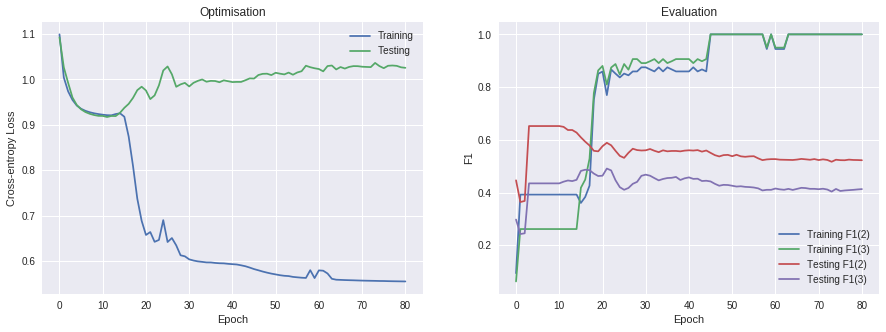

In [296]:
plt.style.use("seaborn")
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title("Optimisation")
plt.plot(results["training"]["cross_entropy_loss"][::batches])
plt.plot(results["testing"]["cross_entropy_loss"][::batches])
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy Loss")
plt.legend(["Training", "Testing"])

plt.subplot(1, 2, 2)
plt.title("Evaluation")
plt.plot(results["training"]["f_1_2"][::batches])
plt.plot(results["training"]["f_1_3"][::batches])
plt.plot(results["testing"]["f_1_2"][::batches])
plt.plot(results["testing"]["f_1_3"][::batches])
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend(["Training F1(2)", "Training F1(3)", "Testing F1(2)", "Testing F1(3)"])

## Evaluation

In [297]:
model = get_model(optimal_model_state_dict)

In [298]:
_, predictions, _ = model(*testing_inputs)

In [299]:
print(classification_report(testing.stances, predictions.cpu()))

              precision    recall  f1-score   support

           0       0.34      0.17      0.22       230
           1       0.63      0.40      0.49       304
           2       0.67      0.88      0.76       715

    accuracy                           0.63      1249
   macro avg       0.54      0.48      0.49      1249
weighted avg       0.60      0.63      0.59      1249



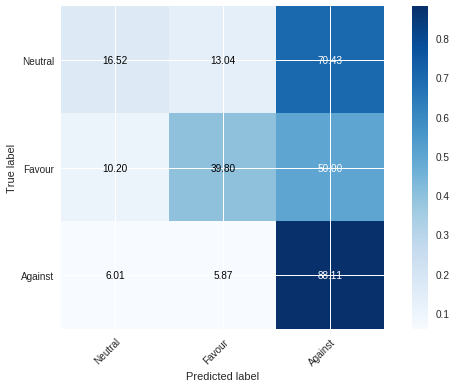

In [300]:
plot_confusion_matrix(testing.stances, predictions.cpu())